이번 코스에선 문장 데이터를 직접 토큰화하며 어떤 방법이 가장 적합한 단어 조각을 만들어 내는지 실습해보도록 하겠습니다.

---

이번 코스에서는 KoNLPy, 그중에서도 가장 성능이 준수한 MeCab클래스를 활용해 실습하도록 하겠습니다!

클라우드 환경에는 이미 설치되어 있습니다. 아래 링크에서 확인만 해보세요.

* [설치하기 - KoNLPy 0.5.2 documentation](https://konlpy.org/ko/latest/install/)
설치가 완료된 후엔 아주 간편하게 import 하여 형태소 분석기를 사용하실 수 있습니다.

# 목차

* 데이터 다운로드 및 분석
* 공백 기반 토큰화
* 형태소 기반 토큰화
* 프로젝트:SentencePiece 사용하기
* 회고
* Reference

In [ ]:
from konlpy.tag import Mecab

mecab = Mecab()
print(mecab.morphs('자연어처리가너무재밌어서밥먹는것도가끔까먹어요'))

['자연어', '처리', '가', '너무', '재밌', '어서', '밥', '먹', '는', '것', '도', '가끔', '까먹', '어요']


# 데이터 다운로드 및 분석

먼저 프로젝트에 사용될 라이브러리를 import 합니다.

In [ ]:
import os

import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

%matplotlib inline

그럼 학습환경을 구성하고 데이터를 다운받아 보겠습니다.

\$ wget https://github.com/jungyeul/korean-parallel-corpora/raw/master/korean-english-news-v1/korean-english-park.train.tar.gz
\$ mkdir -p ~/aiffel/sp_tokenizer/data
\$ mv korean-english-park.train.tar.gz ~/aiffel/sp_tokenizer/data
\$ cd ~/aiffel/sp_tokenizer/data
\$ tar -xzvf korean-english-park.train.tar.gz

In [ ]:
import os
path_to_file = os.getenv('HOME')+'/aiffel/sp_tokenizer/data/korean-english-park.train.ko'

with open(path_to_file, "r") as f:
    raw = f.read().splitlines()

print("Data Size:", len(raw))

print("Example:")
for sen in raw[0:100][::20]: print(">>", sen)

Data Size: 94123
Example:
>> 개인용 컴퓨터 사용의 상당 부분은 "이것보다 뛰어날 수 있느냐?"
>> 북한의 핵무기 계획을 포기하도록 하려는 압력이 거세지고 있는 가운데, 일본과 북한의 외교관들이 외교 관계를 정상화하려는 회담을 재개했다.
>> "경호 로보트가 침입자나 화재를 탐지하기 위해서 개인적으로, 그리고 전문적으로 사용되고 있습니다."
>> 수자원부 당국은 논란이 되고 있고, 막대한 비용이 드는 이 사업에 대해 내년에 건설을 시작할 계획이다.
>> 또한 근력 운동은 활발하게 걷는 것이나 최소한 20분 동안 뛰는 것과 같은 유산소 활동에서 얻는 운동 효과를 심장과 폐에 주지 않기 때문에, 연구학자들은 근력 운동이 심장에 큰 영향을 미치는지 여부에 대해 논쟁을 해왔다.


내려받은 데이터는 한국어의 형태소 분석과 품사 태깅, 기계 번역 연구를 위해 공개된 데이터입니다. 이번에 사용할 데이터는 한국어-영어 병렬을 이루는 말뭉치 중 한국어 부분으로, 전체 병렬 말뭉치는 후에 번역기를 만들며 사용할 예정입니다!

자, 데이터가 우리 손으로 들어왔으니 씹고 뜯고 맛볼 차례입니다! 멋진 시각화를 동반한 통계적 분석...까지는 하지 않고요. 최소한의 분석으로 데이터가 얼마나 있고, 어떻게 생겼는지 정도를 직접 확인해 봅시다.

문장은 위에서 확인한 것처럼 94123개가 포함되어 있습니다. 우리는 각 문장이 어느 정도의 길이를 가지는지 확인해보겠습니다! 이 과정을 거치면 지나치게 긴 데이터를 삭제하거나 (연산량을 감소시켜 학습 속도가 빨라집니다!) 지나치게 짧은 데이터를 검증 (무조건 필요가 없지는 않습니다, 단어 ↔ 단어 라면 번역을 학습할 수 있겠죠!) 할 수 있습니다. 즉, 데이터를 얼마나 사용할지 타협점을 정의할 수 있습니다.

아래 소스는 문장의 최단 길이, 최장 길이, 평균 길이를 구한 후 문장 길이 분포를 막대그래프로 표현해 주는 소스입니다. raw 변수는 앞서 다운로드받은 데이터가 담긴 변수입니다!

문장의 최단 길이: 1
문장의 최장 길이: 377
문장의 평균 길이: 60


/tmp/ipykernel_31/2284205290.py:15: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sentence_length = np.zeros((max_len), dtype=np.int)


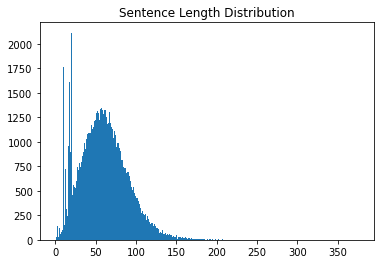

In [ ]:
min_len = 999
max_len = 0
sum_len = 0

for sen in raw:
    length = len(sen)
    if min_len > length: min_len = length
    if max_len < length: max_len = length
    sum_len += length

print("문장의 최단 길이:", min_len)
print("문장의 최장 길이:", max_len)
print("문장의 평균 길이:", sum_len // len(raw))

sentence_length = np.zeros((max_len), dtype=np.int)

for sen in raw:
    sentence_length[len(sen)-1] += 1

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

최단 길이 1, 최장 길이 377... 그리고 제법 그럴듯한 막대그래프가 나왔습니다만, 이 결과를 확인하고 드는 생각은 아래와 크게 다르지 않으실 거예요..!

1) 길이 1 짜리 문장은 도대체 어떻게 생겨먹었지?

2) 앞에 치솟는 임의의 구간은 뭐지? 유의미한 데이터가 담겨있는 부분인가?

3) 어디서부터 어디까지 잘라서 쓰지?

궁금증을 하나하나 해결해 봅시다! 대체 길이가 1인 문장은 뭘까요?

In [ ]:
def check_sentence_with_length(raw, length):
    count = 0
    
    for sen in raw:
        if len(sen) == length:
            print(sen)
            count += 1
            if count > 100: return

check_sentence_with_length(raw, 1)

’


오잉? 하마터면 완전 노이즈인 데이터를 그대로 사용할 뻔했습니다! 왠지 길이별로 확인할 일이 많을 것 같아 함수를 미리 정의해두었는데, 이를 이용해 확인이 필요해 보이는 문장은 모두 확인해보죠.

In [ ]:
for idx, _sum in enumerate(sentence_length):
    # 문장의 수가 1500을 초과하는 문장 길이를 추출합니다.
    if _sum > 1500:
        print("Outlier Index:", idx+1)

Outlier Index: 11
Outlier Index: 19
Outlier Index: 21


In [ ]:
check_sentence_with_length(raw, 11)

라고 조던이 말했다.
- 모르고 있습니다.
- 네, 보이는군요.
디즈니사만이 아니다.
큰 파티는 아니지요.
의자는 비어 있었다.
이 일은 계속됩니다.
나는 크게 실망했다.
그 이유는 간단하다.
이력서와 자기 소개서
시대가 변하고 있다.
는 돌발질문을 했다.
9. 몇 분간의 명상
하와이, 빅 아일랜드
키스를 잘 하는 방법
키스를 잘 하는 방법
스피어스가 뚱뚱한가?
산 위를 나는 느낌.
세 시간쯤 걸었을까?
(아직 읽고있습니까?
처음에는 장난이었다.
우리는 운이 좋았다.
아기가 숨을 멈출 때
건물 전체 무너져내려
그녀의 아름다운 눈.
대답은 다음과 같다.
"사과할 것이 없다.
폭탄테러가 공포 유발
그는 "잘 모르겠다.
그는 "잘 모르겠다.
그는 "잘 모르겠다.
그는 "잘 모르겠다.
그는 "잘 모르겠다.
그는 "잘 모르겠다.
그는 "잘 모르겠다.
그는 "잘 모르겠다.
그는 "잘 모르겠다.
케냐 야생동물 고아원
경유 1200원대로…
더 내려야 하는 이유
케냐 야생동물 고아원
경유 1200원대로…
더 내려야 하는 이유
케냐 야생동물 고아원
경유 1200원대로…
더 내려야 하는 이유
케냐 야생동물 고아원
경유 1200원대로…
더 내려야 하는 이유
케냐 야생동물 고아원
경유 1200원대로…
더 내려야 하는 이유
케냐 야생동물 고아원
경유 1200원대로…
더 내려야 하는 이유
케냐 야생동물 고아원
경유 1200원대로…
더 내려야 하는 이유
케냐 야생동물 고아원
경유 1200원대로…
더 내려야 하는 이유
케냐 야생동물 고아원
경유 1200원대로…
더 내려야 하는 이유
케냐 야생동물 고아원
경유 1200원대로…
더 내려야 하는 이유
케냐 야생동물 고아원
경유 1200원대로…
더 내려야 하는 이유
케냐 야생동물 고아원
경유 1200원대로…
더 내려야 하는 이유
케냐 야생동물 고아원
경유 1200원대로…
더 내려야 하는 이유
케냐 야생동물 고아원
경유 1200원대로…
더 내려야 하는 이유
케냐 야생동물 고아원
경유 1200원대로…
더 내려야 하는 이유
케냐 야생동물 고아원
경유 1

이런... 심지어 중복에 대한 처리도 제대로 하지 않았었네요. 중복 제거는 Python의 기본 자료형 set을 활용할 겁니다. set은 집합을 정의하는 자료형인데, 중복을 허용하지 않아 변환 과정에서 자동으로 중복된 요소를 제거해 주거든요! 대신 list의 순서가 뒤죽박죽될 수 있으니, 만약 번역 데이터처럼 쌍을 이뤄야 하는 경우라면 주의해서 사용하셔야 합니다!

중복을 제거한 후, 앞에서 분포를 확인한 소스를 다시 실행시켜 보겠습니다!

Data Size: 77591
문장의 최단 길이: 1
문장의 최장 길이: 377
문장의 평균 길이: 64


/tmp/ipykernel_31/390535405.py:18: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sentence_length = np.zeros((max_len), dtype=np.int)


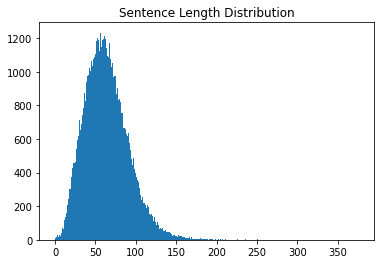

In [ ]:
min_len = 999
max_len = 0
sum_len = 0

cleaned_corpus = list(set(raw))  # set를 사용해서 중복을 제거합니다.
print("Data Size:", len(cleaned_corpus))

for sen in cleaned_corpus:
    length = len(sen)
    if min_len > length: min_len = length
    if max_len < length: max_len = length
    sum_len += length

print("문장의 최단 길이:", min_len)
print("문장의 최장 길이:", max_len)
print("문장의 평균 길이:", sum_len // len(cleaned_corpus))

sentence_length = np.zeros((max_len), dtype=np.int)

for sen in cleaned_corpus:   # 중복이 제거된 코퍼스 기준
    sentence_length[len(sen)-1] += 1

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

이제서야 깔끔한 데이터를 얻은 느낌이 드네요. 데이터의 개수도 17000개가량 줄어 77591 개가 되었습니다.

마지막으로 '모든 데이터를 다 사용할 것이냐' 가 문제인데, 후에 미니 배치를 만들 것을 생각하면 모든 데이터를 다 사용하는 것은 연산 측면에서 비효율적입니다. 미니 배치 특성상 각 데이터의 크기가 모두 동일해야 하기 때문에 가장 긴 데이터를 기준으로 Padding 처리를 해야 합니다. 위의 데이터에서 만약 길이가 100인 문장까지만 사용한다면 데이터는 [ (77591 - 길이 100 초과 문장 수) x 100 ] 의 형태를 갖겠지만 모두 사용할 경우 [ 77591 x 377 ] 로 전자보다 최소 3.7배 큰 메모리를 차지합니다. 학습 시간도 그만큼 더 오래 걸리고요.

길이별로 정렬하여 미니 배치를 구성해 Padding을 최소화하는 방법도 있지만 이는 데이터를 섞는 데 편향성이 생길 수 있으므로 지양해야 합니다. 여기서는 길이 150 이상의 데이터를 제거하고 사용하도록 할게요!

그리고 앞서 확인한 것처럼 너무 짧은 데이터는 오히려 노이즈로 작용할 수 있습니다. 따라서 길이가 10 미만인 데이터도 제거하도록 하죠!

/tmp/ipykernel_31/1483434014.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sentence_length = np.zeros((max_len), dtype=np.int)


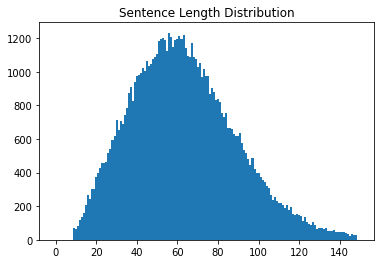

In [ ]:
max_len = 150
min_len = 10

# 길이 조건에 맞는 문장만 선택합니다.
filtered_corpus = [s for s in cleaned_corpus if (len(s) < max_len) & (len(s) >= min_len)]

# 분포도를 다시 그려봅니다.
sentence_length = np.zeros((max_len), dtype=np.int)

for sen in filtered_corpus:
    sentence_length[len(sen)-1] += 1

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

이제 정말 사용할 준비가 된 것 같죠? 본격적인 작업을 시작해봅시다!

# 공백 기반 토큰화

배운 순서대로, 먼저 공백 기반 토큰화를 진행해 봅시다!

정제된 데이터를 공백 기반으로 토큰화하여 list에 저장한 후, 아래 tokenize() 함수를 사용해 단어 사전과 Tensor 데이터를 얻으세요! 그리고 단어 사전의 크기를 확인하세요!

In [ ]:
def tokenize(corpus):  # corpus: Tokenized Sentence's List
    tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
    tokenizer.fit_on_texts(corpus)

    tensor = tokenizer.texts_to_sequences(corpus)

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

    return tensor, tokenizer

In [ ]:
split_corpus = []

for kor in filtered_corpus:
    split_corpus.append(kor.split())

이제 공백 기반 토큰화를 진행한 후, 단어 사전의 길이를 확인해봅시다.

In [ ]:
split_tensor, split_tokenizer = tokenize(split_corpus)

print("Split Vocab Size:", len(split_tokenizer.index_word))

Split Vocab Size: 237435


In [ ]:
# 아래의 코드로 생성된 단어 사전을 확인해 볼 수 있습니다.

for idx, word in enumerate(split_tokenizer.word_index):
    print(idx, ":", word)

    if idx > 10: break

0 : 이
1 : 밝혔다.
2 : 있다.
3 : 말했다.
4 : 수
5 : 있는
6 : 그는
7 : 대한
8 : 위해
9 : 전했다.
10 : 지난
11 : 이번


동사로 이루어진 단어를 살피면 공백 기반 토큰화의 문제점을 확인할 수 있습니다. 1번 단어인 밝혔다. 는 밝히다 , 밝다 등과 유사한 의미를 지니고 있음에도 전혀 다른 단어로 분류되겠죠? 이 때문에 공백 기반 토큰화는 불필요하게 큰 단어 사전을 가지게 되며 이는 연산량 증가로 이어집니다.

만일 밝 + 혔다 라고 토큰화했다면 어땠을까요? 밝 + 히다, 밝 + 다 같은 구절이 등장했을 때, 공통된 어절인 밝 은 하나로 묶여 학습 중에 의미를 파악하기가 수월해지겠죠? 동시에 단어 사전도 효율적으로 축소될 것입니다. 이를 위해 형태소 분석기가 존재합니다!

# 형태소 기반 토큰화

한국어 형태소 분석기는 대표적으로 Khaiii와 KoNLPy가 사용됩니다. 이번 코스에서는 KoNLPy, 그중에서도 가장 성능이 준수한 MeCab클래스를 활용해 실습하도록 하겠습니다!

앞서 작성했던 코드를 활용해 MeCab 기반으로 생성된 단어 사전과 Tensor 데이터를 얻어 봅시다!

In [ ]:
def mecab_split(sentence):
    return mecab.morphs(sentence)

mecab_corpus = []

for kor in filtered_corpus:
    mecab_corpus.append(mecab_split(kor))

이제 형태소 기반 토큰화를 진행한 후, 단어 사전의 길이를 확인해 봅시다.

In [ ]:
mecab_tensor, mecab_tokenizer = tokenize(mecab_corpus)

print("MeCab Vocab Size:", len(mecab_tokenizer.index_word))

MeCab Vocab Size: 52279


앞서 실습했던 공백 기반 단어 사전에 비해 단어 수가 현저히 줄어든 것을 확인하셨을 겁니다. 이는 곧 연산량의 감소로 이어져 더 빠른 학습을 가능케 하고, 심지어 모델이 튜닝해야 하는 매개변수(Parameter) 수가 줄어들어 학습도 더 잘 된답니다! 적어도 한국어를 처리할 때는 공백 기반 토큰화를 절대 지양하셔야 해요!

자주 사용되는 SentencePiece같은 Subword 기반 토큰화보다 형태소 분석기가 좋은 성능을 내는 사례들이 종종 있는데요, ETRI에서 발표한 한국어 BERT 모델인 KorBERT가 대표적인 사례 중 하나입니다. 아래 웹페이지를 방문하면 모델의 자세한 구조뿐 아니라 KorBERT 모델을 5가지 자연어 처리 태스크를 기준으로 평가했던 흥미로운 결과까지 살펴보실 수 있습니다!

* [공공 인공지능 오픈 API·DATA 서비스 포털](https://aiopen.etri.re.kr/service_dataset.php)

자연어 처리에서 토크나이저가 성능에 미치는 영향도가 크다는 것은 주지의 사실입니다만, 위 링크에서 발표된 평가 결과를 살펴볼 때 몇 가지 생각해 볼 만한 지점이 있습니다.

아래 질문들에 대해 스스로 생각해 보고 본인의 생각을 정리해서 답변해 보시기 바랍니다. 사실 정답이 있는 문제는 아니기 때문입니다.

https://lms.aiffel.io/course/366/node/457/step/3043

지금까지 문장을 Tensor로 Encoding하는 과정을 배웠는데요.
후에 모델이 생성한 Tensor를 문장으로 Decoding하는 과정도 필요하겠죠?

tokenizer.sequences_to_texts() 함수를 사용하여 Decoding
tokenizer.index_word 를 사용하여 Decoding

두 가지 방법으로 mecab_tensor[100] 을 원문으로 되돌려 보세요!
(여기서 띄어쓰기는 고려하지 않습니다!)

In [ ]:
# Case 1
texts = mecab_tokenizer.sequences_to_texts([mecab_tensor[100]])
print(texts[0])

저 는 ap 라디오 뉴스 의 존 벨몬트 였 습니다 . clinton global initiative 클린턴 글로벌 이니셔티브 , 클린턴 전 대통령 이 창설 한 자선 회의


In [ ]:
# Case 2
sentence = ""

for w in mecab_tensor[100]:
    if w == 0: continue
    sentence += mecab_tokenizer.index_word[w] + " "

print(sentence)

저 는 ap 라디오 뉴스 의 존 벨몬트 였 습니다 . clinton global initiative 클린턴 글로벌 이니셔티브 , 클린턴 전 대통령 이 창설 한 자선 회의 


# 프로젝트: SentencePiece 사용하기

라이브러리 버전을 확인해 봅니다

----
사용할 라이브러리 버전을 둘러봅시다.

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib as plt
import konlpy

print(tf.__version__)
print(np.__version__)
print(plt.__version__)
print(konlpy.__version__)

2.6.0
1.21.4
3.4.3
0.5.2


## 루브릭

아래의 기준을 바탕으로 프로젝트를 평가합니다.

-----
평가문항	상세기준

1. SentencePiece를 이용하여 모델을 만들기까지의 과정이 정상적으로 진행되었는가?

> 코퍼스 분석, 전처리, SentencePiece 적용, 토크나이저 구현 및 동작이 빠짐없이 진행되었는가?

2. SentencePiece를 통해 만든 Tokenizer가 자연어처리 모델과 결합하여 동작하는가?

> SentencePiece 토크나이저가 적용된 Text Classifier 모델이 정상적으로 수렴하여 80% 이상의 test accuracy가 확인되었다.

3. SentencePiece의 성능을 다각도로 비교분석하였는가?

> SentencePiece 토크나이저를 활용했을 때의 성능을 다른 토크나이저 혹은 SentencePiece의 다른 옵션의 경우와 비교하여 분석을 체계적으로 진행하였다.

## Step 1. SentencePiece 설치하기

SentencePiece는 Google에서 제공하는 오픈소스 기반 Sentence Tokenizer/Detokenizer 로서, BPE와 unigram 2가지 subword 토크나이징 모델 중 하나를 선택해서 사용할 수 있도록 패키징한 것입니다. 아래 링크의 페이지에서 상세한 내용을 파악할 수 있습니다.

* [google/sentencepiece](https://github.com/google/sentencepiece)

위 페이지의 서두에서도 언급하고 있듯, SentencePiece는 딥러닝 자연어처리 모델의 앞부분에 사용할 목적으로 최적화되어 있는데, 최근 pretrained model들이 거의 대부분 SentencePiece를 tokenizer로 채용하면서 사실상 표준의 역할을 하고 있습니다.

다음과 같이 설치를 진행합니다. SentencePiece는 python에서 쓰라고 만들어진 라이브러리는 아니지만 편리한 파이썬 wrapper를 아래와 같이 제공하고 있습니다.

$ pip install sentencepiece

In [ ]:
!pip install sentencepiece

## Step 2. SentencePiece 모델 학습

앞서 배운 tokenize() 함수를 기억하나요? 다시 한번 상기시켜드릴게요!

def tokenize(corpus):  # corpus: Tokenized Sentence's List
    tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
    tokenizer.fit_on_texts(corpus)

    tensor = tokenizer.texts_to_sequences(corpus)

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

    return tensor, tokenizer
    
위와 같이 tf.keras.preprocessing.text.Tokenizer에 corpus를 주고 tokenizer.fit_on_texts(corpus)을 하면 토크나이저 내부적으로 단어사전과 토크나이저 기능을 corpus에 맞춤형으로 자동 생성해 주는 것입니다.

그럼 이를 위해서 SentencePiece 모델을 학습하는 과정을 거쳐야 합니다.

In [ ]:
import sentencepiece as spm
import os
temp_file = os.getenv('HOME')+'/aiffel/sp_tokenizer/data/korean-english-park.train.ko.temp'

vocab_size = 8000

with open(temp_file, 'w') as f:
    for row in filtered_corpus:   # 이전 스텝에서 정제했던 corpus를 활용합니다.
        f.write(str(row) + '\n')

spm.SentencePieceTrainer.Train(
    '--input={} --model_prefix=korean_spm --vocab_size={}'.format(temp_file, vocab_size)    
)
#위 Train에서  --model_type = 'unigram'이 디폴트 적용되어 있습니다. --model_type = 'bpe' 로 옵션을 주어 변경할 수 있습니다.

!ls -l korean_spm*

sentencepiece_trainer.cc(177) LOG(INFO) Running command: --input=/aiffel/aiffel/sp_tokenizer/data/korean-english-park.train.ko.temp --model_prefix=korean_spm --vocab_size=8000
sentencepiece_trainer.cc(77) LOG(INFO) Starts training with : 
trainer_spec {
  input: /aiffel/aiffel/sp_tokenizer/data/korean-english-park.train.ko.temp
  input_format: 
  model_prefix: korean_spm
  model_type: UNIGRAM
  vocab_size: 8000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id

-rw-r--r-- 1 root root 376816 Nov 29 06:37 korean_spm.model
-rw-r--r-- 1 root root 146213 Nov 29 06:37 korean_spm.vocab


위 코드를 실행하면 정상적으로 SentencePiece 모델 학습이 완료된 후 korean_spm.model 파일과 korean_spm.vocab vocabulary 파일이 생성되었음을 확인할 수 있습니다.

그럼 이렇게 학습된 SentencePiece 모델을 어떻게 활용하는지 살펴보겠습니다.



In [ ]:
s = spm.SentencePieceProcessor()
s.Load('korean_spm.model')

# SentencePiece를 활용한 sentence -> encoding
tokensIDs = s.EncodeAsIds('아버지가방에들어가신다.')
print(tokensIDs)

# SentencePiece를 활용한 sentence -> encoded pieces
print(s.SampleEncodeAsPieces('아버지가방에들어가신다.',1, 0.0))

# SentencePiece를 활용한 encoding -> sentence 복원
print(s.DecodeIds(tokensIDs))

# 어떻습니까? SentencePiece의 토크나이징 실력이 괜찮은 것 같습니다.

[1243, 11, 302, 7, 3608, 11, 287, 38, 3]
['▁아버지', '가', '방', '에', '들어', '가', '신', '다', '.']
아버지가방에들어가신다.


## Step 3. Tokenizer 함수 작성

우리는 위에서 훈련시킨 SentencePiece를 활용하여 위 함수와 유사한 기능을 하는 sp_tokenize() 함수를 정의할 겁니다. 하지만 SentencePiece가 동작하는 방식이 단순 토큰화와는 달라 완전히 동일하게는 정의하기 어렵습니다. 그러니 아래 조건을 만족하는 함수를 정의하도록 하습니다.

> 1. 매개변수로 토큰화된 문장의 list를 전달하는 대신 온전한 문장의 list 를 전달합니다.

> 2. 생성된 vocab 파일을 읽어와 { <word\> : <idx\> } 형태를 가지는 word_index 사전과 { <idx\> : <word\>} 형태를 가지는 index_word 사전을 생성하고 함께 반환합니다.

> 3. 리턴값인 tensor 는 앞의 함수와 동일하게 토큰화한 후 Encoding된 문장입니다. 바로 학습에 사용할 수 있게 Padding은 당연히 해야겠죠?



In [ ]:
def sp_tokenize(s, corpus):

    tensor = []

    for sen in corpus:
        tensor.append(s.EncodeAsIds(sen))

    with open("./korean_spm.vocab", 'r') as f:
        vocab = f.readlines()

    word_index = {}
    index_word = {}

    for idx, line in enumerate(vocab):
        word = line.split("\t")[0]

        word_index.update({word:idx})
        index_word.update({idx:word})

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

    return tensor, word_index, index_word

In [ ]:
#sp_tokenize(s, corpus) 사용예제

my_corpus = ['나는 밥을 먹었습니다.', '그러나 여전히 ㅠㅠ 배가 고픕니다...']
tensor, word_index, index_word = sp_tokenize(s, my_corpus)
print(tensor)

[[1956 5665    5    4 7975 1990    3    0    0    0    0    0    0    0]
 [ 107 1641  101    4    0  417   11    4   14    0 1976    3    3    3]]


## Step 4. 네이버 영화리뷰 감정 분석 문제에 SentencePiece 적용해 보기

[네이버 영화리뷰 감정 분석 태스크](https://github.com/e9t/nsmc/)가 있습니다. 한국어로 된 corpus를 다루어야 하므로 주로 KoNLPy에서 제공하는 형태소 분석기를 사용하여 텍스트를 전처리해서 RNN 모델을 분류기로 사용하게 되는데요.

만약 이 문제에서 tokenizer를 SentencePiece로 바꾸어 다시 풀어본다면 더 성능이 좋아질까요? KoNLPy에 있는 Mecab, kkma, Okt 등과 비교해보세요.

1. 네이버 영화리뷰 감정 분석 코퍼스에 SentencePiece를 적용시킨 모델 학습하기
2. 학습된 모델로 sp_tokenize() 메소드 구현하기
3. 구현된 토크나이저를 적용하여 네이버 영화리뷰 감정 분석 모델을 재학습하기
4. KoNLPy 형태소 분석기를 사용한 모델과 성능 비교하기
5. SentencePiece 모델의 model_type, vocab_size 등을 변경해 가면서 성능 개선 여부 확인하기

Word Vector는 활용할 필요가 없습니다. 활용이 가능하지도 않을 것입니다.

### 라이브러리 임포팅

In [ ]:
import pandas as pd
import konlpy
import gensim

### 데이터 불러오기

In [ ]:
# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/text_preprocess/ratings_train.txt')
test_data = pd.read_table('~/aiffel/text_preprocess/ratings_test.txt')

display(train_data.head())
display(test_data.head())

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0


In [ ]:
# 데이터 크기 확인
print(len(train_data))
print(len(test_data))

150000
50000


In [ ]:
# 중복되는 데이터 제거
train_data.drop_duplicates(subset=['document'], inplace=True)
test_data.drop_duplicates(subset=['document'], inplace=True)

# 결측치가 있는 행 제거
train_data = train_data.dropna()
test_data = test_data.dropna()

# 데이터 크기 다시 확인
print(len(train_data))
print(len(test_data))


146182
49157


### 데이터 전처리

In [ ]:
# 학습 데이터 전처리
# 한글과 공백을 제외한 문자들을 모두 공백으로 바꾼다.

train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
train_data[:5]

/tmp/ipykernel_31/3655971363.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")


,id,document,label
0,9976970,아 더빙 진짜 짜증나네요 목소리,0
1,3819312,흠포스터보고 초딩영화줄오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 솔직히 재미는 없다평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화스파이더맨에서 늙어보이기만 했던 커스틴 던...,1


In [ ]:
# 테스트 데이터 전처리
# 한글과 공백을 제외한 문자들을 모두 공백으로 바꾼다.

test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
test_data[:5]

/tmp/ipykernel_31/3173845585.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")


,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,,0
2,8544678,뭐야 이 평점들은 나쁘진 않지만 점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임 돈주고 보기에는,0
4,6723715,만 아니었어도 별 다섯 개 줬을텐데 왜 로 나와서 제 심기를 불편하게 하죠,0


Data Size: 146182
문장의 최단 길이: 0
문장의 최장 길이: 140
문장의 평균 길이: 32


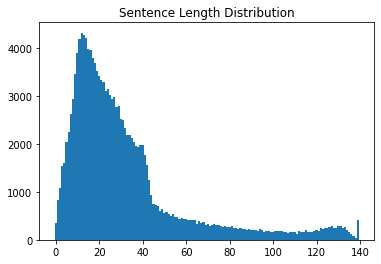

In [ ]:
# 데이터의 문장 길이 조절

min_len = 999
max_len = 0
sum_len = 0

print("Data Size:", len(train_data))

for sen in train_data['document']:
    length = len(sen)
    if min_len > length: min_len = length
    if max_len < length: max_len = length
    sum_len += length

print("문장의 최단 길이:", min_len)
print("문장의 최장 길이:", max_len)
print("문장의 평균 길이:", sum_len // len(train_data))

sentence_length = np.zeros((max_len), dtype=np.int64)

for sen in train_data['document']: 
    sentence_length[len(sen)-1] += 1

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

In [ ]:
length_check = 50
i = 0

for sen in train_data['document']:
    length = len(sen)
    if length > length_check: i += 1
        
rate = i*100/len(train_data)
print("문장의 길이가", length_check, "보다 긴 문장의 비율은", rate, "%입니다. "  )

문장의 길이가 50 보다 긴 문장의 비율은 16.116211298244654 %입니다. 


* 위에서 데이터의 문장 길이 분포를 보니 대부분의 데이터가 해당되는 길이인 50개 안 쪽으로 두면 될 것으로 보인다.
* 문장의 길이가 0인 데이터는 필요 없으므로 최소길이는 1로 둔다.

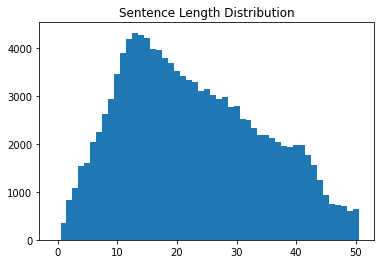

In [ ]:
max_len = 50
min_len = 1

# 길이 조건에 맞는 문장만 선택합니다.
filtered_train = [s for s in train_data['document'] if (len(s) <= max_len) & (len(s) >= min_len)]

# 분포도를 다시 그려봅니다.
sentence_length = np.zeros((max_len + 1), dtype=np.int64)

for sen in filtered_train:
    sentence_length[len(sen)] += 1

plt.bar(range(max_len+1), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

In [ ]:
# 테스트 데이터에도 적용하여 새로운 데이터로 만든다.

filtered_train = [s for s in train_data['document'] if (len(s) <= max_len) & (len(s) >= min_len)]
filtered_test = [s for s in test_data['document'] if (len(s) <= max_len) & (len(s) >= min_len)]

train_list = list(set(filtered_train))
test_list = list(set(filtered_test))

train_df = pd.DataFrame(train_list)
test_df = pd.DataFrame(test_list)

new_train_df = pd.merge(train_data, train_df, how='inner', left_on='document', right_on=0)
new_test_df = pd.merge(test_data, test_df, how='inner', left_on='document', right_on=0)

train_data = new_train_df[['id', 'document', 'label']]
test_data = new_test_df[['id', 'document', 'label']]

display(train_data.head())
display(test_data.head())

,id,document,label
0,9976970,아 더빙 진짜 짜증나네요 목소리,0
1,3819312,흠포스터보고 초딩영화줄오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 솔직히 재미는 없다평점 조정,0
4,5403919,막 걸음마 뗀 세부터 초등학교 학년생인 살용영화ㅋㅋㅋ별반개도 아까움,0


,id,document,label
0,6270596,굳 ㅋ,1
1,8544678,뭐야 이 평점들은 나쁘진 않지만 점 짜리는 더더욱 아니잖아,0
2,6825595,지루하지는 않은데 완전 막장임 돈주고 보기에는,0
3,6723715,만 아니었어도 별 다섯 개 줬을텐데 왜 로 나와서 제 심기를 불편하게 하죠,0
4,7898805,음악이 주가 된 최고의 음악영화,1


In [ ]:
print('학습 데이터:',len(train_data))
print('테스트 데이터:',len(test_data))

학습 데이터: 122232
테스트 데이터: 41071


### sp_tokenize

step 2,3 에서 사용한 함수들을 다시 확인해보자

In [ ]:
# sp_tokenize로 토큰화

X_train, X_train_word_index, X_train_index_word = sp_tokenize(s, train_data['document'])
X_test, X_test_word_index, X_test_index_word = sp_tokenize(s, test_data['document'])

# label 값을 y_train, y_test로 둔다.

y_train = np.array(list(train_data['label']))
y_test = np.array(list(test_data['label']))

In [ ]:
# 토큰화 결과 확인

print('train')
print(X_train[:3])
print(y_train[:3])
print()

print('test')
print(X_test[:3])
print(y_test[:3])

train
[[ 141  106 2611  912 4856    4 4856  752   69  554  514 2648    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0]
 [   4 7663  466 1756  146   14  439 3174 2766 1791  175  408  381   41
  4189    4   11 7570   29 1311  230   69    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0]
 [1328  437    0  266  254  591   95  146   10 1960    5 1011  703  249
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0]]
[0 1 0]

test
[[   4 7888    4    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [   4 7826  168   25 1089  344  

In [ ]:
# validation set 만들기

from sklearn.model_selection import train_test_split

# 일반적으로 훈련 데이터셋과 검증 데이터셋은 8:2 로 나눈다.
train_input, val_input, train_target, val_target = train_test_split(X_train, y_train, 
                                                                    test_size=0.2, 
                                                                    random_state=34)

### 모델 학습 및 평가

In [ ]:
import sentencepiece as spm
import os
temp_file = os.getenv('HOME')+'/aiffel/sp_tokenizer/data/korean-english-park.train.ko.temp'

vocab_size = 8000

with open(temp_file, 'w') as f:
    for row in filtered_corpus:   # 이전 스텝에서 정제했던 corpus를 활용합니다.
        f.write(str(row) + '\n')

spm.SentencePieceTrainer.Train(
    '--input={} --model_prefix=korean_spm --vocab_size={}'.format(temp_file, vocab_size)    
)
# 위 Train에서  --model_type = 'unigram'이 디폴트 적용되어 있습니다. --model_type = 'bpe' 로 옵션을 주어 변경할 수 있습니다.

!ls -l korean_spm*

sentencepiece_trainer.cc(177) LOG(INFO) Running command: --input=/aiffel/aiffel/sp_tokenizer/data/korean-english-park.train.ko.temp --model_prefix=korean_spm --vocab_size=8000
sentencepiece_trainer.cc(77) LOG(INFO) Starts training with : 
trainer_spec {
  input: /aiffel/aiffel/sp_tokenizer/data/korean-english-park.train.ko.temp
  input_format: 
  model_prefix: korean_spm
  model_type: UNIGRAM
  vocab_size: 8000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id

-rw-r--r-- 1 root root 376816 Nov 29 11:33 korean_spm.model
-rw-r--r-- 1 root root 146213 Nov 29 11:33 korean_spm.vocab


In [ ]:
s = spm.SentencePieceProcessor()
s.Load('korean_spm.model')

True

In [ ]:
def sp_tokenize(s, corpus):

    tensor = []

    for sen in corpus:
        tensor.append(s.EncodeAsIds(sen))

    with open("./korean_spm.vocab", 'r') as f:
        vocab = f.readlines()

    word_index = {}
    index_word = {}

    for idx, line in enumerate(vocab):
        word = line.split("\t")[0]

        word_index.update({idx:word})
        index_word.update({word:idx})

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

    return tensor, word_index, index_word

In [ ]:
# 이전 노드에서 썼었던 LSTM 모델 사용(1)

vocab_size = 5000    # 어휘 사전의 크기
word_vector_dim = 20  # 단어 하나를 표현하는 임베딩 벡터의 차원수 (변경가능)

from tensorflow import keras
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size,word_vector_dim))
model.add(keras.layers.LSTM(8))
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 20)          100000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 8)                 928       
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 9         
Total params: 101,009
Trainable params: 101,009
Non-trainable params: 0
_________________________________________________________________


In [ ]:
from keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=2, verbose=1) 

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(train_input, train_target, epochs=20, validation_data=(val_input, val_target), callbacks=[early_stop])

Epoch 1/20
3056/3056 [==============================] - 17s 5ms/step - loss: 0.6620 - accuracy: 0.5764 - val_loss: 0.6281 - val_accuracy: 0.7025
Epoch 2/20
3056/3056 [==============================] - 16s 5ms/step - loss: 0.6064 - accuracy: 0.7000 - val_loss: 0.6133 - val_accuracy: 0.6845
Epoch 3/20
3056/3056 [==============================] - 16s 5ms/step - loss: 0.6147 - accuracy: 0.6689 - val_loss: 0.5978 - val_accuracy: 0.7101
Epoch 4/20
3056/3056 [==============================] - 16s 5ms/step - loss: 0.5848 - accuracy: 0.7064 - val_loss: 0.5599 - val_accuracy: 0.7329
Epoch 5/20
3056/3056 [==============================] - 16s 5ms/step - loss: 0.5399 - accuracy: 0.7399 - val_loss: 0.5283 - val_accuracy: 0.7493
Epoch 6/20
3056/3056 [==============================] - 16s 5ms/step - loss: 0.4919 - accuracy: 0.7678 - val_loss: 0.4954 - val_accuracy: 0.7642
Epoch 7/20
3056/3056 [==============================] - 15s 5ms/step - loss: 0.4636 - accuracy: 0.7842 - val_loss: 0.4927 - val_ac

* vocab_size = 5000, word_vector_dim = 20 일 때의 결과는 다음과 같다.

In [ ]:
lstm_result = model.evaluate(X_test, y_test, verbose=2)
print(lstm_result)

1284/1284 - 3s - loss: 0.4525 - accuracy: 0.7904
[0.45252519845962524, 0.7904117107391357]


In [ ]:
# 이전 노드에서 썼었던 LSTM 모델 사용(2)

vocab_size = 10000    # 어휘 사전의 크기
word_vector_dim = 20  # 단어 하나를 표현하는 임베딩 벡터의 차원수 (변경가능)

from tensorflow import keras
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size,word_vector_dim))
model.add(keras.layers.LSTM(8))
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, None, 20)          200000    
_________________________________________________________________
lstm_5 (LSTM)                (None, 8)                 928       
_________________________________________________________________
dense_10 (Dense)             (None, 8)                 72        
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 9         
Total params: 201,009
Trainable params: 201,009
Non-trainable params: 0
_________________________________________________________________


In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=2, verbose=1) 

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(train_input, train_target, epochs=20, validation_data=(val_input, val_target), callbacks=[early_stop])

Epoch 1/20
3056/3056 [==============================] - 17s 5ms/step - loss: 0.5217 - accuracy: 0.7429 - val_loss: 0.4432 - val_accuracy: 0.8023
Epoch 2/20
3056/3056 [==============================] - 16s 5ms/step - loss: 0.4139 - accuracy: 0.8174 - val_loss: 0.4087 - val_accuracy: 0.8125
Epoch 3/20
3056/3056 [==============================] - 16s 5ms/step - loss: 0.3783 - accuracy: 0.8317 - val_loss: 0.4066 - val_accuracy: 0.8158
Epoch 4/20
3056/3056 [==============================] - 16s 5ms/step - loss: 0.3563 - accuracy: 0.8408 - val_loss: 0.4038 - val_accuracy: 0.8183
Epoch 5/20
3056/3056 [==============================] - 16s 5ms/step - loss: 0.3387 - accuracy: 0.8501 - val_loss: 0.4060 - val_accuracy: 0.8217
Epoch 6/20
3056/3056 [==============================] - 16s 5ms/step - loss: 0.3236 - accuracy: 0.8586 - val_loss: 0.4043 - val_accuracy: 0.8165
Epoch 00006: early stopping


* 위와 같이 vocab_size = 10000 으로 키웠을 때의 결과는 다음과 같다.

In [ ]:
lstm_result = model.evaluate(X_test, y_test, verbose=2)
print(lstm_result)

1284/1284 - 3s - loss: 0.4014 - accuracy: 0.8185
[0.401365727186203, 0.8184850811958313]


### 형태소 기반 토큰화와 비교

In [ ]:
import numpy as np
from collections import Counter
from konlpy.tag import Mecab
from MeCab import Tagger

tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['', '', '', ''] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
        
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index[''] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)

In [ ]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [ ]:
# 비어있는 것들에 할당

word_to_index["<PAD>"] = 0
word_to_index["<BOS>"] = 1
word_to_index["<UNK>"] = 2  # unknown
word_to_index["<UNUSED>"] = 3

index_to_word = {index:word for word, index in word_to_index.items()}

print(index_to_word[3])

<UNUSED>


In [ ]:
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre', # 혹은 'post'
                                                        maxlen=50)

X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre', # 혹은 'post'
                                                       maxlen=50)

print(X_train.shape)

(120122, 50)


In [ ]:
# validation set 만들기

from sklearn.model_selection import train_test_split

# 일반적으로 훈련 데이터셋과 검증 데이터셋은 8:2 로 나눈다.
train_input, val_input, train_target, val_target = train_test_split(X_train, y_train, 
                                                                    test_size=0.2, 
                                                                    random_state=34)

In [ ]:
# 이전 노드에서 썼었던 LSTM 모델 사용(3)

vocab_size = 10000    # 어휘 사전의 크기
word_vector_dim = 20  # 단어 하나를 표현하는 임베딩 벡터의 차원수 (변경가능)

from tensorflow import keras
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size,word_vector_dim))
model.add(keras.layers.LSTM(8))
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, None, 20)          200000    
_________________________________________________________________
lstm_8 (LSTM)                (None, 8)                 928       
_________________________________________________________________
dense_16 (Dense)             (None, 8)                 72        
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 9         
Total params: 201,009
Trainable params: 201,009
Non-trainable params: 0
_________________________________________________________________


In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=2, verbose=1) 

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(train_input, train_target, epochs=20, validation_data=(val_input, val_target), callbacks=[early_stop])

Epoch 1/20
3004/3004 [==============================] - 17s 5ms/step - loss: 0.4039 - accuracy: 0.8157 - val_loss: 0.3649 - val_accuracy: 0.8362
Epoch 2/20
3004/3004 [==============================] - 16s 5ms/step - loss: 0.3268 - accuracy: 0.8564 - val_loss: 0.3538 - val_accuracy: 0.8432
Epoch 3/20
3004/3004 [==============================] - 16s 5ms/step - loss: 0.2898 - accuracy: 0.8744 - val_loss: 0.3548 - val_accuracy: 0.8450
Epoch 4/20
3004/3004 [==============================] - 16s 5ms/step - loss: 0.2599 - accuracy: 0.8893 - val_loss: 0.3706 - val_accuracy: 0.8440
Epoch 00004: early stopping


* 위와 같이 형태소 기반 토큰화인 MeCab 을 사용했을 때의 결과는 다음과 같다.

In [ ]:
lstm_result = model.evaluate(X_test, y_test, verbose=2)
print(lstm_result)

1266/1266 - 3s - loss: 0.3671 - accuracy: 0.8431
[0.3670845031738281, 0.8430593013763428]


### 결과

같은 조건에서 SentencePiece 토크나이저를 사용했을 때는 정확도가 81.8% 를 기록했다.
반면 형태소 기반 토크나이저 MeCab을 사용했을 때는 정확도가 84.3% 를 기록했다.

# 회고

이번 노드에서는 센텐스피스를 활용해 토큰화하여 모델에 적용해보았다. 비록 이번 프로젝트에서는 형태소 기반 토크나이저인 MeCab 이 조금 더 높은 정확도를 보였으나 센텐스피스는 비교적 간단하게 언어에 상관없이 적용할 수 있기 때문에 이 정도 차이는 충분히 무시할만하다고 보인다. 특히 영어 같은 언어와는 달리 한국어는 교착어로, 토큰화가 매우 힘든 편에 속한다. 그럼에도 불구하고 한국어 전용 토크나이저와 비슷한 수준의 성능을 보인다는 점에서 충분히 가능성을 볼 수 있었다.

# Reference

https://wikidocs.net/86657 SentencePiece 에 대해